In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt

In [2]:
NER = spacy.load('it_core_news_sm')

In [3]:
#NOW WE'RE READY TO BEGIN WITH NAMED ENTITY RECOGNITION
#*STEPS*
#Tokenize the script into a list of sentences. Label each sentence by the label of the characters
#Define the window size, i.e. how far two sentences are apart from each other. We propose here a network visualization in which each character is represented by a node connected with the characters that appear in the same scenes. 
# Resuming: 
#Two characters are connected if they appear in the same scene.
#Their size and color intensity are proportional to their weighted degree (degree=number of connections)
#The ‘network density’ measures how close the graph is to complete. A complete graph (100%) has all possible edges between its nodes.

In [45]:
script= 'data/Filumena.txt'
script_text = open(script, encoding='utf-8').read()
script_doc = NER(script_text)

In [46]:
# quick test - identified entities
displacy.render(script_doc[0:2000], style="ent", jupyter=True)

In [50]:
# Read characters
character_df = pd.read_csv("data/characters.csv")
#character_df

,book,character
0,Category:Filumena Marturano (traduzione di Pao...,Domenico Soriano
1,Category:Filumena Marturano (traduzione di Pao...,Alfredo Amoroso
2,Category:Filumena Marturano (traduzione di Pao...,Filomena Marturano
3,Category:Filumena Marturano (traduzione di Pao...,Rosalia Solimene
4,Category:Filumena Marturano (traduzione di Pao...,Primo Facchino
5,Category:Filumena Marturano (traduzione di Pao...,Secondo Facchino
6,Category:Filumena Marturano (traduzione di Pao...,Diana
7,Category:Filumena Marturano (traduzione di Pao...,Lucia
8,Category:Filumena Marturano (traduzione di Pao...,Avvocato Nocella
9,Category:Filumena Marturano (traduzione di Pao...,Umberto


In [51]:
import re 
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x)) 
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])

In [53]:
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in script_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [21]:
sent_entity_df


,sentence,entities
0,"(﻿ATTO, PRIMO, \n, SCENA, PRIMA, \n, (, DOMENI...","[PRIMO \nSCENA PRIMA, DOMENICO, ALFREDO, FILOM..."
1,"(Cento, volte, ,, mille, volte, !)",[]
2,"(ALFREDO, (, Con, un, timido, gesto, intervien...",[ALFREDO]
3,"(Rosalia, si, avvicina, a, Filomena, e, le, po...","[Rosalia, Filomena]"
4,"(DOMENICO, Io, sono, un, uomo, da, niente, !)",[DOMENICO Io]
...,...,...
1657,"(Il, volto, le, si, riga, di, lacrime, come, a...",[]
1658,"(Domenico, preoccupato, le, si, avvicina, ), F...","[Domenico, Filomena]"
1659,"(FILOMENA, (, Felice, ), Domenico, ,, sto, pia...","[FILOMENA, Felice, Domenico, DOMENICO, Stringe..."
1660,"(Hai, corso, …, hai, corso, …, hai, avuto, pau...","[Hai, Riposati!..., Hai, Filomena]"


In [54]:
# Function to filter out non-character entities
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list 
            if ent in list(character_df.character) 
            or ent in list(character_df.character_firstname)]

In [55]:
filter_entity(["Filomena", "Thu", "2"], character_df)

['Filomena']

In [56]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

# Filter out sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
3,"(Rosalia, si, avvicina, a, Filomena, e, le, po...","[Rosalia, Filomena]","[Rosalia, Filomena]"
6,"((, Con, un, lampo, di, odio, negli, occhi, a,...",[Filomena],[Filomena]
9,"(Che, altro, deve, ancora, dart, Domenico, Sor...",[Domenico Soriano],[Domenico Soriano]
13,"((, Il, pensiero, del, tiro, giuocatogli, da, ...",[Filomena],[Filomena]
22,"(il, medico, ,, il, prete, …, (, Mostrando, Ro...","[Mostrando Rosalia, Alfredo]",[Alfredo]
28,"(Mi, sono, svegliato, ,, ho, capito, !, ..., (...","[Filomena, Tu te ne vai…]",[Filomena]
29,"(Non, c’, è, alcuna, legge, ,, non, c’, è, nes...","[Dio, Domenico Soriano]",[Domenico Soriano]
51,"(Filomena, ,, ma, stai, dando, i, numeri, stas...",[Filomena],[Filomena]
57,"((, Mostra, Alfredo, e, Rosalia, ), ROSALIA, (...","[Mostra, Alfredo, Rosalia, Pronta, Io non so n...","[Alfredo, Rosalia, Filomena]"
59,"(DOMENICO, (, Ad, Alfredo, ), Tu, neanche, sai...","[DOMENICO, Alfredo]",[Alfredo]


In [57]:
# Take only first name of characters
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
                                                                                                               for item in x])


C:\Users\Eleonora\AppData\Local\Temp\ipykernel_15416\1239962011.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]


In [58]:
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered

,sentence,entities,character_entities
3,"(Rosalia, si, avvicina, a, Filomena, e, le, po...","[Rosalia, Filomena]","[Rosalia, Filomena]"
6,"((, Con, un, lampo, di, odio, negli, occhi, a,...",[Filomena],[Filomena]
9,"(Che, altro, deve, ancora, dart, Domenico, Sor...",[Domenico Soriano],[Domenico]
13,"((, Il, pensiero, del, tiro, giuocatogli, da, ...",[Filomena],[Filomena]
22,"(il, medico, ,, il, prete, …, (, Mostrando, Ro...","[Mostrando Rosalia, Alfredo]",[Alfredo]
...,...,...,...
1648,"(I, TRE, (, Uscendo, seguiti, da, Alfredo, ,, ...","[Uscendo, Alfredo, Rosalia, Lucia]","[Alfredo, Rosalia, Lucia]"
1649,"(Domenico, li, ha, seguiti, con, lo, sguardo, ...",[Domenico],[Domenico]
1658,"(Domenico, preoccupato, le, si, avvicina, ), F...","[Domenico, Filomena]","[Domenico, Filomena]"
1659,"(FILOMENA, (, Felice, ), Domenico, ,, sto, pia...","[FILOMENA, Felice, Domenico, DOMENICO, Stringe...",[Domenico]


In [59]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [60]:
relationship_df = pd.DataFrame(relationships)

In [61]:
pd.set_option('display.max_rows', None)
relationship_df

,source,target
0,Rosalia,Filomena
1,Rosalia,Filomena
2,Rosalia,Filomena
3,Rosalia,Filomena
4,Filomena,Domenico
5,Filomena,Domenico
6,Filomena,Domenico
7,Domenico,Filomena
8,Domenico,Filomena
9,Filomena,Domenico


In [62]:
# Sort the cases with a->b and b->a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df

,source,target
0,Filomena,Rosalia
1,Filomena,Rosalia
2,Filomena,Rosalia
3,Filomena,Rosalia
4,Domenico,Filomena
5,Domenico,Filomena
6,Domenico,Filomena
7,Domenico,Filomena
8,Domenico,Filomena
9,Domenico,Filomena


In [63]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [64]:
relationship_df

,source,target,value
0,Filomena,Rosalia,77
1,Domenico,Filomena,112
2,Alfredo,Rosalia,79
3,Alfredo,Filomena,36
4,Alfredo,Domenico,31
5,Domenico,Rosalia,28
6,Riccardo,Umberto,52
7,Alfredo,Diana,11
8,Diana,Filomena,27
9,Diana,Domenico,53


In [65]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

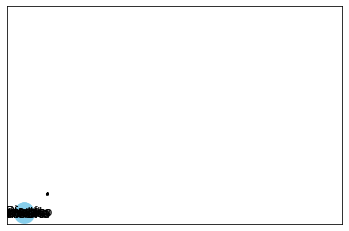

In [66]:

#plt.rcParams["figure.figsize"] = (10,8)
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()


#plt.rcParams["figure.figsize"] = (10,8)

In [67]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("witcher.html")

witcher.html


In [68]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict
#number of times the circles touches the edges is the degree
#in the dictionary we see that gandalf should be the largest node in our graph


{'Filomena': 1.0,
 'Rosalia': 1.0,
 'Domenico': 0.8,
 'Alfredo': 0.5,
 'Riccardo': 0.6000000000000001,
 'Umberto': 0.7000000000000001,
 'Diana': 0.6000000000000001,
 'Lucia': 0.9,
 'Michele': 0.5,
 'Avvocato': 0.5,
 'Teresina': 0.30000000000000004}

<Axes: >

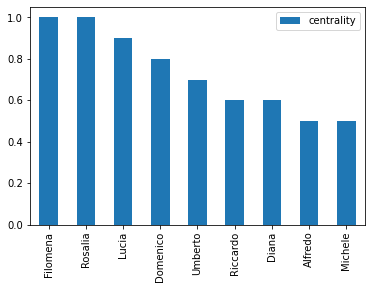

In [69]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

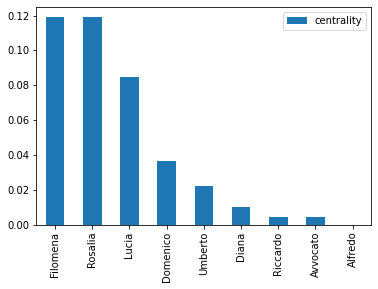

In [70]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

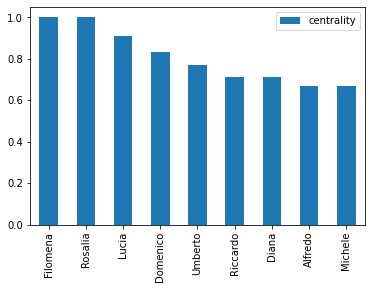

In [71]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [72]:
import community as community_louvain

In [73]:
communities = community_louvain.best_partition(G)

In [74]:
communities

{'Filomena': 1,
 'Rosalia': 1,
 'Domenico': 0,
 'Alfredo': 0,
 'Riccardo': 1,
 'Umberto': 1,
 'Diana': 0,
 'Lucia': 0,
 'Michele': 1,
 'Avvocato': 1,
 'Teresina': 1}

In [75]:
nx.set_node_attributes(G, communities, 'group')

In [76]:
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("witcher_communities.html")

witcher_communities.html
